#Assignment

space-challenge
Algorithm Challenge

The year is 2081, and you work for Astra Luxury Travel, a space adventure company that curates premium voyages across the Solar System. From exquisite getaways to the red deserts of Mars, to leisure cruises among Saturn’s rings, our team of Space Travel Agents ensures every customer enjoys the perfect experience—from initial Earth departure to safe return. Astra empowers humanity to explore the stars in style and comfort.

Your Team: Enterprise Intelligence

The Enterprise Intelligence Department at Astra Luxury Travel is the organization’s data-driven nerve center. Our mission is to harness advanced analytics, predictive modeling, and applied AI to maximize revenue for Astra.

Project

Your team must develop a real-time SQL assignment algorithm that automatically matches prospective customers with the best travel agent available. Agents not only guide customers through the booking process but also upsell luxury packages, exclusive excursions, and custom accommodations. At the end of each journey, customers rate their experience with their travel agent. Your solution should receive details about a customer (listed below) and return a stack-ranked list of travel agents ordered from best to worst.

Details known at time of assignment:

Customer Name
Communication Method
Lead Source
Destination
Launch Location
Requirements

Provide a written overview of your model and the approach you chose
Provide SQL Code that can be executed without errors
If your model requires the building of new tables, stored procedures or functions, make sure you provide the SQL code that creates them

We need to design a SQL-based system to match new customers with the most suitable travel agents, based on limited input at the time of assignment (customer name, communication method, lead source, destination, and launch location). The goal is to return a ranked list of agents who are best positioned to deliver a high-quality customer experience.

📄 Overview of Approach: Space Travel Agent Assignment

1. Problem Understanding
We are tasked with designing a SQL algorithm that, when given a new customer’s details (Customer Name, Communication Method, Lead Source, Destination, Launch Location), returns a ranked list of the best available travel agents. The goal is to match customers with agents most likely to succeed—measured by successful bookings and high customer service ratings.

2. Assumptions
- Agent performance is based on historical booking success and customer service ratings.
- Matching will benefit from shared attributes (e.g., familiarity with destination, preferred communication method, lead source experience).
- “Bookings” provide outcome context via total revenue and booking status.
- “Assignment history” tells us how agents have interacted with specific lead sources and communication types in the past.

3. Key Tables Used
- `space_travel_agents`: Agent metadata, including rating and years of experience.
- `assignment_history`: Agent assignments and customer metadata at time of lead.
- `bookings`: Links assignments to booking outcomes, with destination and financial metrics.

4. Matching Logic
We calculate a composite score for each agent based on:
- Historical success with the given destination (Confirmed bookings).
- Prior experience with the customer’s communication method and lead source.
- Overall customer rating.
- Bonus: agents with more confirmed bookings and higher revenue in similar scenarios.

The result is a ranked list of agents by match score.

5. Final Output
The query returns:
- AgentID, Full Name, Score, Customer Service Rating, Match Breakdown

6. Next Steps
This model can evolve into a more dynamic scoring system via stored procedures or real-time APIs. With additional data (e.g., agent availability), machine learning could be introduced for deeper personalization.

In [1]:
# --- SQL-based Scoring Model Using SQLite ---


In [2]:
import sqlite3
import pandas as pd
import re
from ast import literal_eval

# === STEP 1: Load the SQL text files ===
with open("assignment_history SQL Table.txt", "r") as f:
    assignment_raw = f.read()

with open("bookings SQL Table.txt", "r") as f:
    bookings_raw = f.read()

with open("space_travel_agents SQL Table.txt", "r") as f:
    agents_raw = f.read()

# === STEP 2: Parse SQL INSERT blocks (handles NULL) ===
def parse_sql_insert_block_with_null(raw_sql: str) -> list:
    matches = re.findall(r"VALUES\s*(.*?);", raw_sql, re.DOTALL)
    if not matches:
        return []

    values_str = matches[0].replace("NULL", "None")
    values_str = re.sub(r"\),\s*\(", r")|(", values_str.strip()[1:-1])
    tuple_strings = values_str.split("|")

    parsed = []
    for t in tuple_strings:
        try:
            parsed.append(literal_eval(f"({t})"))
        except:
            print("Failed to parse:", t)
            continue
    return parsed

# === STEP 3: Parse into DataFrames ===
assignment_columns = ['AssignmentID', 'AgentID', 'CustomerName', 'CommunicationMethod', 'LeadSource', 'AssignedDateTime']
bookings_columns = ['BookingID', 'AssignmentID', 'BookingCompleteDate', 'CancelledDate', 'Destination', 'Package', 'LaunchLocation', 'DestinationRevenue', 'PackageRevenue', 'TotalRevenue', 'BookingStatus']
agents_columns = ['AgentID', 'FirstName', 'LastName', 'Email', 'JobTitle', 'DepartmentName', 'ManagerName', 'SpaceLicenseNumber', 'YearsOfService', 'AverageCustomerServiceRating']

assignment_data = parse_sql_insert_block_with_null(assignment_raw)
bookings_data = parse_sql_insert_block_with_null(bookings_raw)
agents_data = parse_sql_insert_block_with_null(agents_raw)

df_assignment = pd.DataFrame(assignment_data, columns=assignment_columns)
df_bookings = pd.DataFrame(bookings_data, columns=bookings_columns)
df_agents = pd.DataFrame(agents_data, columns=agents_columns)

# === STEP 4: Create in-memory SQLite DB and write dataframes to tables ===
conn = sqlite3.connect(":memory:")
df_assignment.to_sql("assignment_history", conn, index=False)
df_bookings.to_sql("bookings", conn, index=False)
df_agents.to_sql("space_travel_agents", conn, index=False)

# === STEP 5: Run SQL query to compute scoring model ===
query = """
WITH confirmed_bookings AS (
    SELECT
        a.AgentID,
        COUNT(b.BookingID) AS ConfirmedBookings,
        AVG(b.TotalRevenue) AS AvgRevenue
    FROM assignment_history a
    JOIN bookings b ON a.AssignmentID = b.AssignmentID
    WHERE b.BookingStatus = 'Confirmed'
    GROUP BY a.AgentID
),
agent_base AS (
    SELECT
        AgentID,
        AverageCustomerServiceRating
    FROM space_travel_agents
),
joined AS (
    SELECT
        cb.AgentID,
        cb.ConfirmedBookings,
        cb.AvgRevenue,
        ab.AverageCustomerServiceRating
    FROM confirmed_bookings cb
    JOIN agent_base ab ON cb.AgentID = ab.AgentID
),
scored AS (
    SELECT
        AgentID,
        ConfirmedBookings,
        AvgRevenue,
        AverageCustomerServiceRating,
        1.0 * ConfirmedBookings / (SELECT MAX(ConfirmedBookings) FROM joined) AS Norm_Confirmed,
        1.0 * AvgRevenue / (SELECT MAX(AvgRevenue) FROM joined) AS Norm_Revenue,
        1.0 * AverageCustomerServiceRating / (SELECT MAX(AverageCustomerServiceRating) FROM joined) AS Norm_Rating
    FROM joined
)
SELECT
    AgentID,
    ConfirmedBookings,
    AvgRevenue,
    AverageCustomerServiceRating,
    ROUND(0.4 * Norm_Confirmed + 0.3 * Norm_Revenue + 0.3 * Norm_Rating, 3) AS CompositeScore
FROM scored
ORDER BY CompositeScore DESC
LIMIT 10;
"""

sql_results = pd.read_sql_query(query, conn)
print(sql_results)

Failed to parse: 1, 7, 'Evelyn Brooks', 'Phone Call', 'Organic', '2081-02-01 09:00:00')
Failed to parse: (450, 11, 'Mira Cruz', 'Phone Call', 'Bought', '2081-04-10 15:00:00'
Failed to parse: 1, 1, '2081-02-01 10:00:00', None, 'Mars', 'Luxury Dome Stay', 'Dallas-Fort Worth Launch Complex', 150000, 25000, 175000, 'Confirmed')
Failed to parse: (412, 450, '2081-04-10 14:25:00', None, 'Europa', 'Glacier Trek Adventure', 'Tokyo Spaceport Terminal', 120000, 25000, 145000, 'Confirmed'
Failed to parse: 1, 'Aurora', 'Tanaka', 'aurora.tanaka@astra2081.com', 'Senior Space Travel Agent', 'Interplanetary Sales', 'Lyra Chen', 'SL-2081-001', 12, 4.0)
Failed to parse: (30, 'Zuri', 'Bennett', 'zuri.bennett@astra2081.com', 'Space Travel Agent', 'Interplanetary Sales', 'Lyra Chen', 'SL-2081-030', 2, 3.7
   AgentID  ConfirmedBookings     AvgRevenue  AverageCustomerServiceRating  \
0       19                 15  130000.000000                           4.7   
1       12                 11  156818.181818     

# EDA of DF Assignment


In [3]:
df_assignment.head(100)

,AssignmentID,AgentID,CustomerName,CommunicationMethod,LeadSource,AssignedDateTime
0,2,14,Lucas Chen,Text,Bought,2081-02-01 10:30:00
1,3,3,Amara Patel,Text,Organic,2081-02-01 11:15:00
2,4,25,Jasper Kim,Phone Call,Bought,2081-02-01 13:00:00
3,5,7,Zara Singh,Text,Organic,2081-02-01 14:20:00
4,6,17,Milo Davis,Phone Call,Bought,2081-02-02 09:45:00
...,...,...,...,...,...,...
95,97,20,Jasper Scott,Text,Organic,2081-02-18 11:40:00
96,98,30,Anaya Foster,Text,Bought,2081-02-18 12:55:00
97,99,28,Sawyer Ross,Phone Call,Organic,2081-02-18 14:10:00
98,100,2,Selah Lewis,Text,Bought,2081-02-18 15:25:00


In [4]:
df_assignment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 448 entries, 0 to 447
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   AssignmentID         448 non-null    int64 
 1   AgentID              448 non-null    int64 
 2   CustomerName         448 non-null    object
 3   CommunicationMethod  448 non-null    object
 4   LeadSource           448 non-null    object
 5   AssignedDateTime     448 non-null    object
dtypes: int64(2), object(4)
memory usage: 21.1+ KB


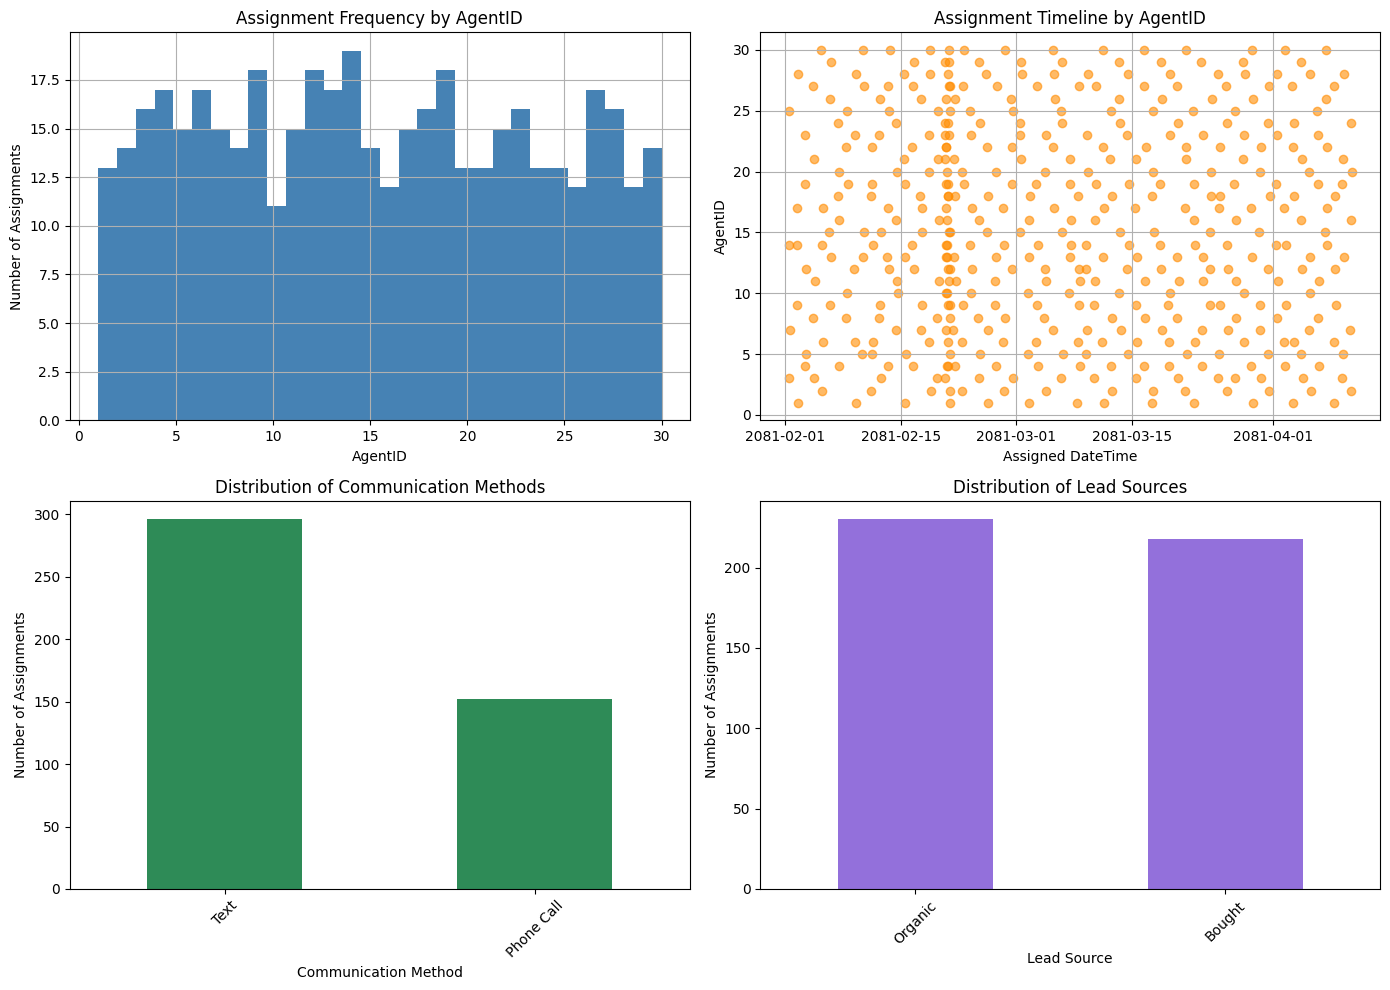

In [5]:
import matplotlib.pyplot as plt

# Ensure datetime is parsed correctly
df_assignment["AssignedDateTime"] = pd.to_datetime(df_assignment["AssignedDateTime"])

# Create 2x2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Histogram of assignments by AgentID
axs[0, 0].hist(df_assignment['AgentID'], bins=df_assignment['AgentID'].nunique(), color='steelblue')
axs[0, 0].set_title("Assignment Frequency by AgentID")
axs[0, 0].set_xlabel("AgentID")
axs[0, 0].set_ylabel("Number of Assignments")
axs[0, 0].grid(True)

# Plot 2: Scatter plot of assignments over time by AgentID
axs[0, 1].scatter(df_assignment['AssignedDateTime'], df_assignment['AgentID'], alpha=0.6, color='darkorange')
axs[0, 1].set_title("Assignment Timeline by AgentID")
axs[0, 1].set_xlabel("Assigned DateTime")
axs[0, 1].set_ylabel("AgentID")
axs[0, 1].grid(True)

# Plot 3: Bar chart of Communication Methods
df_assignment['CommunicationMethod'].value_counts().plot(kind='bar', ax=axs[1, 0], color='seagreen')
axs[1, 0].set_title("Distribution of Communication Methods")
axs[1, 0].set_xlabel("Communication Method")
axs[1, 0].set_ylabel("Number of Assignments")
axs[1, 0].tick_params(axis='x', rotation=45)

# Plot 4: Bar chart of Lead Sources
df_assignment['LeadSource'].value_counts().plot(kind='bar', ax=axs[1, 1], color='mediumpurple')
axs[1, 1].set_title("Distribution of Lead Sources")
axs[1, 1].set_xlabel("Lead Source")
axs[1, 1].set_ylabel("Number of Assignments")
axs[1, 1].tick_params(axis='x', rotation=45)

# Final layout adjustments
plt.tight_layout()
plt.show()

In [6]:
# Count unique values for each column in the assignment history DataFrame
unique_counts = df_assignment.nunique().reset_index()
unique_counts.columns = ['Column', 'Unique Values']

# Display the result
print(unique_counts)

                Column  Unique Values
0         AssignmentID            448
1              AgentID             30
2         CustomerName            438
3  CommunicationMethod              2
4           LeadSource              2
5     AssignedDateTime            445


In [7]:
df_bookings.head()

,BookingID,AssignmentID,BookingCompleteDate,CancelledDate,Destination,Package,LaunchLocation,DestinationRevenue,PackageRevenue,TotalRevenue,BookingStatus
0,2,2,None,2081-02-01 11:00:00,Europa,Zero-Gravity Yacht Cruise,New York Orbital Gateway,120000,20000,140000,Cancelled
1,3,4,2081-02-01 13:30:00,None,Titan,Ringside Cruise,Dubai Interplanetary Hub,140000,30000,170000,Confirmed
2,4,5,None,2081-02-01 15:10:00,Mars,Luxury Dome Stay,Dallas-Fort Worth Launch Complex,150000,25000,175000,Cancelled
3,5,6,2081-02-02 10:00:00,None,Venus,Cloud City Excursion,Tokyo Spaceport Terminal,130000,25000,155000,Confirmed
4,6,8,2081-02-02 12:00:00,None,Mars,Luxury Dome Stay,New York Orbital Gateway,150000,30000,180000,Confirmed


In [8]:
df_bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410 entries, 0 to 409
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   BookingID            410 non-null    int64 
 1   AssignmentID         410 non-null    int64 
 2   BookingCompleteDate  295 non-null    object
 3   CancelledDate        95 non-null     object
 4   Destination          410 non-null    object
 5   Package              410 non-null    object
 6   LaunchLocation       410 non-null    object
 7   DestinationRevenue   410 non-null    int64 
 8   PackageRevenue       410 non-null    int64 
 9   TotalRevenue         410 non-null    int64 
 10  BookingStatus        410 non-null    object
dtypes: int64(5), object(6)
memory usage: 35.4+ KB


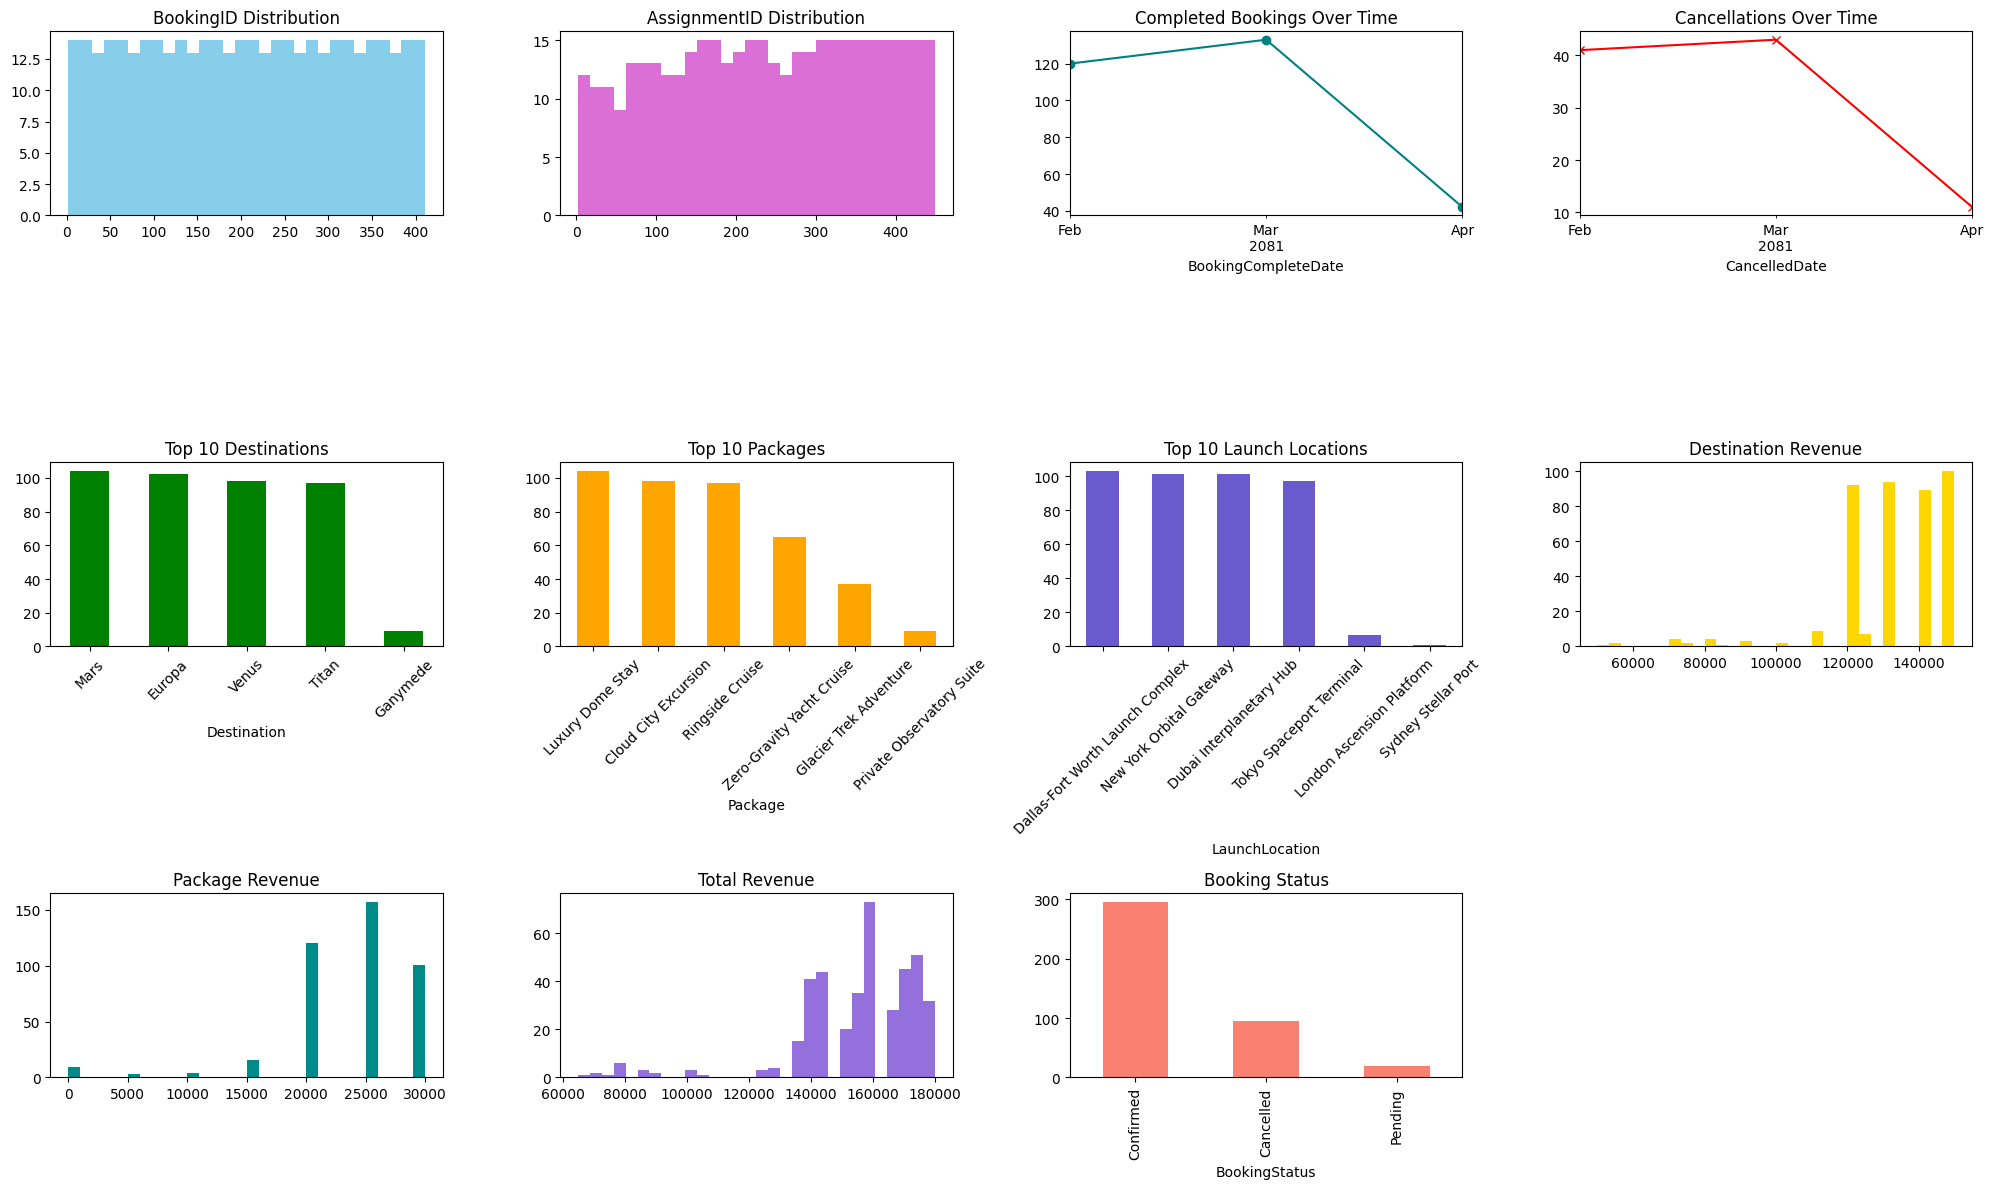

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure datetime columns are properly parsed
df_bookings['BookingCompleteDate'] = pd.to_datetime(df_bookings['BookingCompleteDate'])
df_bookings['CancelledDate'] = pd.to_datetime(df_bookings['CancelledDate'])

# Set up a 3x4 grid for 11 columns
fig, axs = plt.subplots(3, 4, figsize=(20, 12))
axs = axs.flatten()

# Plot 0: BookingID
axs[0].hist(df_bookings['BookingID'], bins=30, color='skyblue')
axs[0].set_title('BookingID Distribution')

# Plot 1: AssignmentID
axs[1].hist(df_bookings['AssignmentID'], bins=30, color='orchid')
axs[1].set_title('AssignmentID Distribution')

# Plot 2: BookingCompleteDate
df_bookings['BookingCompleteDate'].dropna().dt.to_period("M").value_counts().sort_index().plot(
    kind='line', marker='o', ax=axs[2], color='teal')
axs[2].set_title('Completed Bookings Over Time')

# Plot 3: CancelledDate
df_bookings['CancelledDate'].dropna().dt.to_period("M").value_counts().sort_index().plot(
    kind='line', marker='x', ax=axs[3], color='red')
axs[3].set_title('Cancellations Over Time')

# Plot 4: Destination
df_bookings['Destination'].value_counts().head(10).plot(kind='bar', ax=axs[4], color='green')
axs[4].set_title('Top 10 Destinations')
axs[4].tick_params(axis='x', rotation=45)

# Plot 5: Package
df_bookings['Package'].value_counts().head(10).plot(kind='bar', ax=axs[5], color='orange')
axs[5].set_title('Top 10 Packages')
axs[5].tick_params(axis='x', rotation=45)

# Plot 6: LaunchLocation
df_bookings['LaunchLocation'].value_counts().head(10).plot(kind='bar', ax=axs[6], color='slateblue')
axs[6].set_title('Top 10 Launch Locations')
axs[6].tick_params(axis='x', rotation=45)

# Plot 7: DestinationRevenue
axs[7].hist(df_bookings['DestinationRevenue'], bins=30, color='gold')
axs[7].set_title('Destination Revenue')

# Plot 8: PackageRevenue
axs[8].hist(df_bookings['PackageRevenue'], bins=30, color='darkcyan')
axs[8].set_title('Package Revenue')

# Plot 9: TotalRevenue
axs[9].hist(df_bookings['TotalRevenue'], bins=30, color='mediumpurple')
axs[9].set_title('Total Revenue')

# Plot 10: BookingStatus
df_bookings['BookingStatus'].value_counts().plot(kind='bar', ax=axs[10], color='salmon')
axs[10].set_title('Booking Status')

# Hide unused subplot (index 11)
axs[11].axis('off')

# Layout adjustment
plt.tight_layout()
plt.show()

In [10]:
# Step 1: Identify categorical (object) columns
object_columns = df_bookings.select_dtypes(include='object').columns

# Step 2: Create a dictionary of column names and their unique values
unique_values = {col: df_bookings[col].unique().tolist() for col in object_columns}

# Step 3: Convert to DataFrame for clean display (each column = original categorical field)
unique_values_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in unique_values.items()]))

# Step 4: Display the result
unique_values_df.head(20)

,Destination,Package,LaunchLocation,BookingStatus
0,Europa,Zero-Gravity Yacht Cruise,New York Orbital Gateway,Cancelled
1,Titan,Ringside Cruise,Dubai Interplanetary Hub,Confirmed
2,Mars,Luxury Dome Stay,Dallas-Fort Worth Launch Complex,Pending
3,Venus,Cloud City Excursion,Tokyo Spaceport Terminal,NaN
4,Ganymede,Glacier Trek Adventure,London Ascension Platform,NaN
5,NaN,Private Observatory Suite,Sydney Stellar Port,NaN


In [11]:
df_agents.head(100)

,AgentID,FirstName,LastName,Email,JobTitle,DepartmentName,ManagerName,SpaceLicenseNumber,YearsOfService,AverageCustomerServiceRating
0,2,Kai,Rodriguez,kai.rodriguez@astra2081.com,Space Travel Agent,Luxury Voyages,Lyra Chen,SL-2081-002,7,4.0
1,3,Nova,Singh,nova.singh@astra2081.com,Senior Space Travel Agent,Premium Bookings,Zane Holloway,SL-2081-003,15,4.0
2,4,Leo,Kim,leo.kim@astra2081.com,Space Travel Agent,Interplanetary Sales,Lyra Chen,SL-2081-004,5,4.0
3,5,Vera,Nguyen,vera.nguyen@astra2081.com,Space Travel Agent,Luxury Voyages,Zane Holloway,SL-2081-005,3,3.9
4,6,Soren,Baker,soren.baker@astra2081.com,Lead Space Travel Agent,Premium Bookings,Zane Holloway,SL-2081-006,18,4.6
5,7,Mira,Patel,mira.patel@astra2081.com,Space Travel Agent,Interplanetary Sales,Lyra Chen,SL-2081-007,4,4.5
6,8,Orion,Davis,orion.davis@astra2081.com,Senior Space Travel Agent,Luxury Voyages,Zane Holloway,SL-2081-008,10,4.4
7,9,Luna,Martinez,luna.martinez@astra2081.com,Space Travel Agent,Premium Bookings,Zane Holloway,SL-2081-009,6,4.4
8,10,Zara,Khan,zara.khan@astra2081.com,Space Travel Agent,Luxury Voyages,Lyra Chen,SL-2081-010,2,4.0
9,11,Elias,Walker,elias.walker@astra2081.com,Space Travel Agent,Luxury Voyages,Lyra Chen,SL-2081-011,5,4.7


In [12]:
df_agents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   AgentID                       28 non-null     int64  
 1   FirstName                     28 non-null     object 
 2   LastName                      28 non-null     object 
 3   Email                         28 non-null     object 
 4   JobTitle                      28 non-null     object 
 5   DepartmentName                28 non-null     object 
 6   ManagerName                   28 non-null     object 
 7   SpaceLicenseNumber            28 non-null     object 
 8   YearsOfService                28 non-null     int64  
 9   AverageCustomerServiceRating  28 non-null     float64
dtypes: float64(1), int64(2), object(7)
memory usage: 2.3+ KB


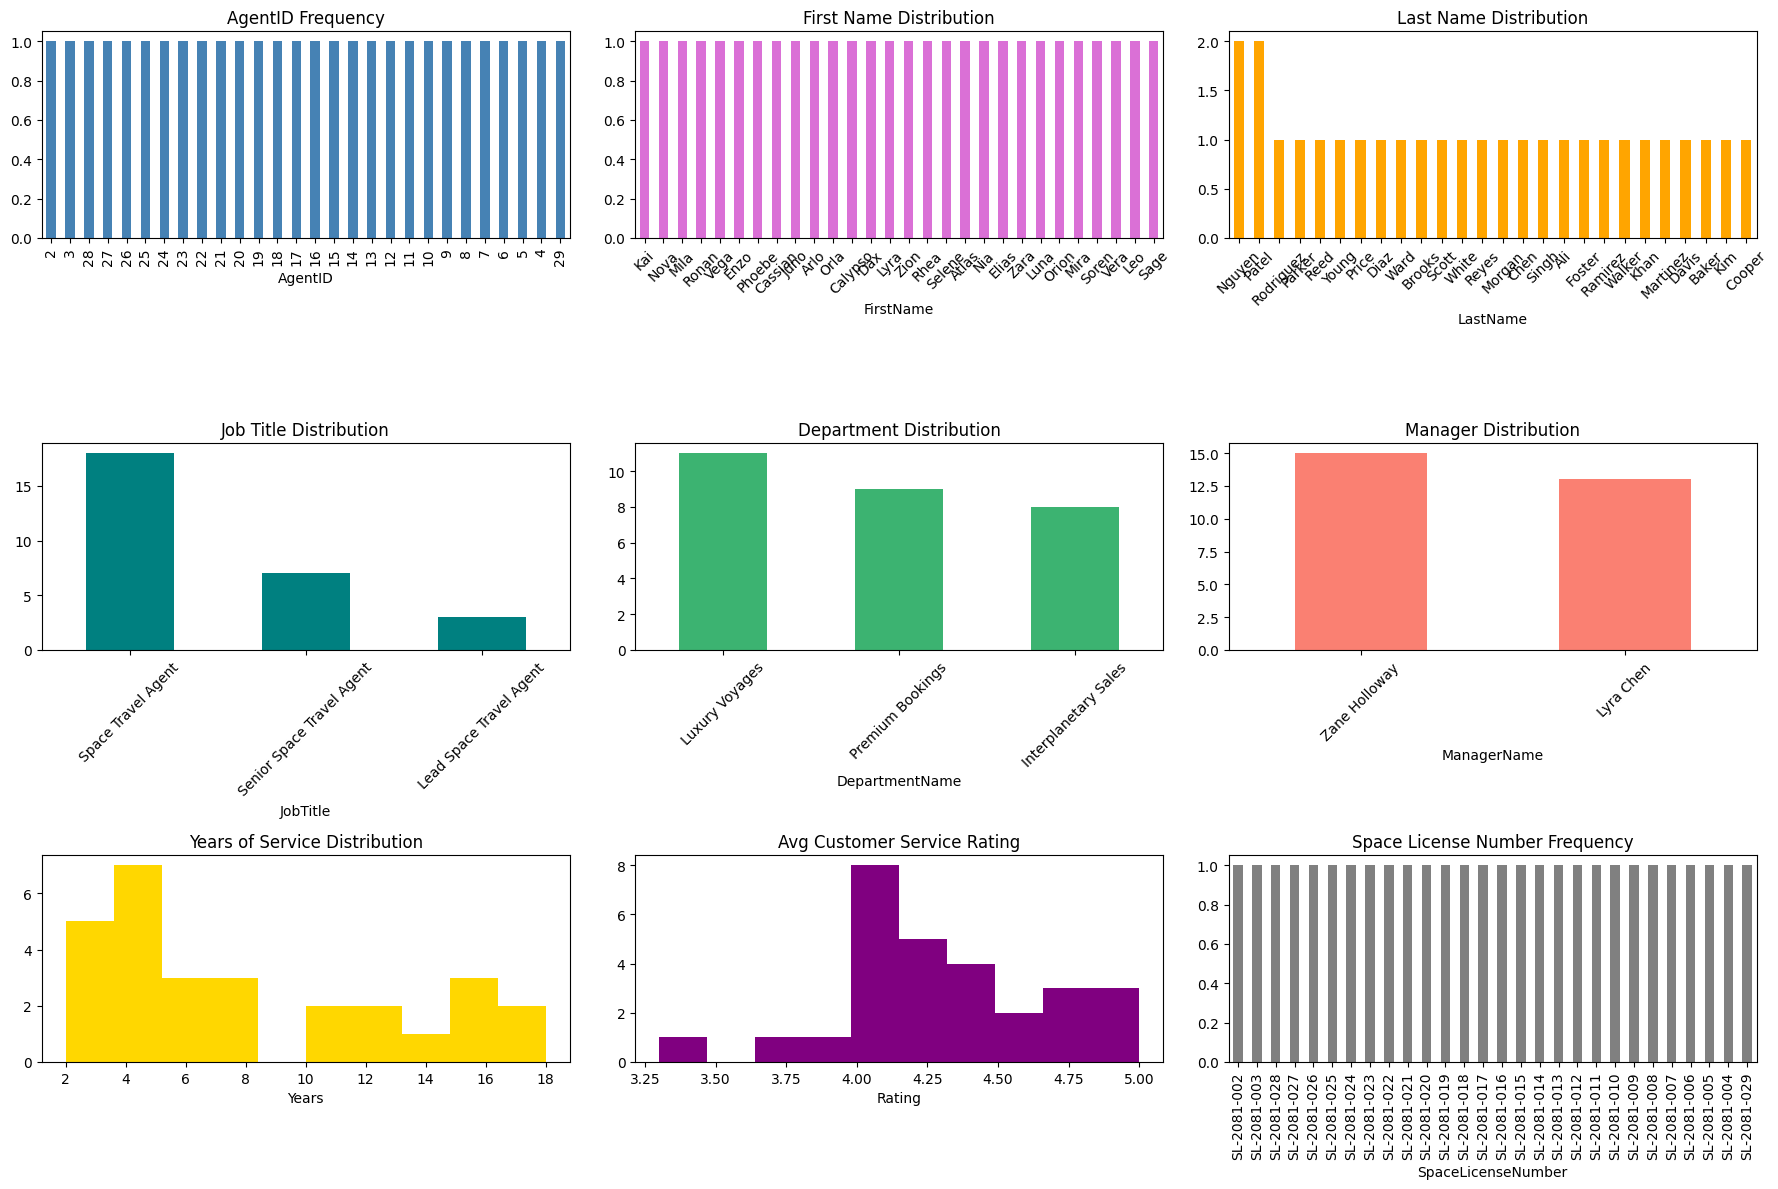

In [13]:
import matplotlib.pyplot as plt

# Set up 3x3 grid for 10 columns
fig, axs = plt.subplots(3, 3, figsize=(18, 12))
axs = axs.flatten()

# Plot 0: AgentID frequency (though all likely unique)
df_agents['AgentID'].value_counts().plot(kind='bar', ax=axs[0], color='steelblue')
axs[0].set_title("AgentID Frequency")
axs[0].set_xlabel("AgentID")

# Plot 1: First Name distribution
df_agents['FirstName'].value_counts().plot(kind='bar', ax=axs[1], color='orchid')
axs[1].set_title("First Name Distribution")
axs[1].tick_params(axis='x', rotation=45)

# Plot 2: Last Name distribution
df_agents['LastName'].value_counts().plot(kind='bar', ax=axs[2], color='orange')
axs[2].set_title("Last Name Distribution")
axs[2].tick_params(axis='x', rotation=45)

# Plot 3: Job Title distribution
df_agents['JobTitle'].value_counts().plot(kind='bar', ax=axs[3], color='teal')
axs[3].set_title("Job Title Distribution")
axs[3].tick_params(axis='x', rotation=45)

# Plot 4: Department Name distribution
df_agents['DepartmentName'].value_counts().plot(kind='bar', ax=axs[4], color='mediumseagreen')
axs[4].set_title("Department Distribution")
axs[4].tick_params(axis='x', rotation=45)

# Plot 5: Manager Name distribution
df_agents['ManagerName'].value_counts().plot(kind='bar', ax=axs[5], color='salmon')
axs[5].set_title("Manager Distribution")
axs[5].tick_params(axis='x', rotation=45)

# Plot 6: Years of Service histogram
axs[6].hist(df_agents['YearsOfService'], bins=10, color='gold')
axs[6].set_title("Years of Service Distribution")
axs[6].set_xlabel("Years")

# Plot 7: Average Customer Rating histogram
axs[7].hist(df_agents['AverageCustomerServiceRating'], bins=10, color='purple')
axs[7].set_title("Avg Customer Service Rating")
axs[7].set_xlabel("Rating")

# Plot 8: Space License Number frequency (likely all unique)
df_agents['SpaceLicenseNumber'].value_counts().plot(kind='bar', ax=axs[8], color='gray')
axs[8].set_title("Space License Number Frequency")
axs[8].tick_params(axis='x', rotation=90)

# Final layout
plt.tight_layout()
plt.show()

In [14]:
# Step 1: Identify all object (categorical) columns
object_columns_agents = df_agents.select_dtypes(include='object').columns

# Step 2: Extract unique values for each categorical column
unique_values_agents = {
    col: df_agents[col].unique().tolist()
    for col in object_columns_agents
}

# Step 3: Convert to a nicely structured DataFrame
unique_values_agents_df = pd.DataFrame(dict([
    (k, pd.Series(v)) for k, v in unique_values_agents.items()
]))

# Step 4: Display the DataFrame
unique_values_agents_df.head(100)

,FirstName,LastName,Email,JobTitle,DepartmentName,ManagerName,SpaceLicenseNumber
0,Kai,Rodriguez,kai.rodriguez@astra2081.com,Space Travel Agent,Luxury Voyages,Lyra Chen,SL-2081-002
1,Nova,Singh,nova.singh@astra2081.com,Senior Space Travel Agent,Premium Bookings,Zane Holloway,SL-2081-003
2,Leo,Kim,leo.kim@astra2081.com,Lead Space Travel Agent,Interplanetary Sales,NaN,SL-2081-004
3,Vera,Nguyen,vera.nguyen@astra2081.com,NaN,NaN,NaN,SL-2081-005
4,Soren,Baker,soren.baker@astra2081.com,NaN,NaN,NaN,SL-2081-006
5,Mira,Patel,mira.patel@astra2081.com,NaN,NaN,NaN,SL-2081-007
6,Orion,Davis,orion.davis@astra2081.com,NaN,NaN,NaN,SL-2081-008
7,Luna,Martinez,luna.martinez@astra2081.com,NaN,NaN,NaN,SL-2081-009
8,Zara,Khan,zara.khan@astra2081.com,NaN,NaN,NaN,SL-2081-010
9,Elias,Walker,elias.walker@astra2081.com,NaN,NaN,NaN,SL-2081-011


In [15]:
import pandas as pd
import re
from ast import literal_eval
from sklearn.preprocessing import MinMaxScaler

# === Load SQL data ===
def parse_sql_insert_block_with_null(raw_sql: str) -> list:
    matches = re.findall(r"VALUES\s*(.*?);", raw_sql, re.DOTALL)
    if not matches:
        return []
    values_str = matches[0].replace("NULL", "None")
    values_str = re.sub(r"\),\s*\(", r")|(", values_str.strip()[1:-1])
    tuple_strings = values_str.split("|")
    parsed = []
    for t in tuple_strings:
        try:
            parsed.append(literal_eval(f"({t})"))
        except:
            continue
    return parsed

with open("assignment_history SQL Table.txt", "r") as f:
    assignment_raw = f.read()

with open("bookings SQL Table.txt", "r") as f:
    bookings_raw = f.read()

with open("space_travel_agents SQL Table.txt", "r") as f:
    agents_raw = f.read()

# Parse to DataFrames
assignment_columns = ['AssignmentID', 'AgentID', 'CustomerName', 'CommunicationMethod', 'LeadSource', 'AssignedDateTime']
bookings_columns = ['BookingID', 'AssignmentID', 'BookingCompleteDate', 'CancelledDate', 'Destination', 'Package', 'LaunchLocation', 'DestinationRevenue', 'PackageRevenue', 'TotalRevenue', 'BookingStatus']
agents_columns = ['AgentID', 'FirstName', 'LastName', 'Email', 'JobTitle', 'DepartmentName', 'ManagerName', 'SpaceLicenseNumber', 'YearsOfService', 'AverageCustomerServiceRating']

df_assignment = pd.DataFrame(parse_sql_insert_block_with_null(assignment_raw), columns=assignment_columns)
df_bookings = pd.DataFrame(parse_sql_insert_block_with_null(bookings_raw), columns=bookings_columns)
df_agents = pd.DataFrame(parse_sql_insert_block_with_null(agents_raw), columns=agents_columns)

# Clean types
df_assignment['AssignedDateTime'] = pd.to_datetime(df_assignment['AssignedDateTime'])
df_bookings['BookingCompleteDate'] = pd.to_datetime(df_bookings['BookingCompleteDate'])
df_bookings['CancelledDate'] = pd.to_datetime(df_bookings['CancelledDate'])

# Merge booking and assignment
df = df_assignment.merge(df_bookings, on='AssignmentID', how='left')

# Filter to confirmed bookings
df_confirmed = df[df['BookingStatus'] == 'Confirmed']

# Aggregate agent metrics
agent_scores = df_confirmed.groupby('AgentID').agg(
    ConfirmedBookings=('BookingID', 'count'),
    AvgRevenue=('TotalRevenue', 'mean'),
    DestExperience=('Destination', pd.Series.nunique),
).reset_index()

# Add total assignments
total_bookings = df.groupby('AgentID').agg(TotalAssigned=('AssignmentID', 'count')).reset_index()
agent_scores = agent_scores.merge(total_bookings, on='AgentID', how='left')

# Add service rating
agent_scores = agent_scores.merge(df_agents[['AgentID', 'AverageCustomerServiceRating']], on='AgentID', how='left')

# Normalize & score
features = ['ConfirmedBookings', 'AvgRevenue', 'AverageCustomerServiceRating']
scaler = MinMaxScaler()
agent_scores[['Norm_' + f for f in features]] = scaler.fit_transform(agent_scores[features])

# Composite score (weights can be changed here)
agent_scores['CompositeScore'] = (
    0.4 * agent_scores['Norm_ConfirmedBookings'] +
    0.3 * agent_scores['Norm_AvgRevenue'] +
    0.3 * agent_scores['Norm_AverageCustomerServiceRating']
)

# Final rank
agent_ranked = agent_scores.sort_values(by='CompositeScore', ascending=False)

# Display top agents
print(agent_ranked[['AgentID', 'ConfirmedBookings', 'AvgRevenue', 'AverageCustomerServiceRating', 'CompositeScore']])

    AgentID  ConfirmedBookings     AvgRevenue  AverageCustomerServiceRating  \
27       28                 10  169500.000000                           4.9   
22       23                 11  156818.181818                           5.0   
11       12                 11  156818.181818                           5.0   
5         6                 12  154166.666667                           4.6   
18       19                 15  130000.000000                           4.7   
21       22                  9  164444.444444                           4.8   
6         7                 10  159000.000000                           4.5   
23       24                 10  162500.000000                           4.3   
2         3                 11  163181.818182                           4.0   
24       25                 10  159500.000000                           4.4   
8         9                  9  163888.888889                           4.4   
12       13                 10  159500.000000       

In [16]:
 # === NEW: Prepare training data for Random Forest ===
 from sklearn.ensemble import RandomForestRegressor
 from sklearn.model_selection import train_test_split

 # Step 1: Merge assignment + bookings + agent data
 df_full = df_assignment.merge(df_bookings, on='AssignmentID', how='left')
 df_full = df_full.merge(df_agents, on='AgentID', how='left')

 # Step 2: Define outcome variable — binary success flag
 df_full['Success'] = df_full['BookingStatus'].eq('Confirmed').astype(int)

 # Step 3: Select features and clean
 df_model = df_full[[
     'CommunicationMethod', 'LeadSource', 'Destination', 'LaunchLocation',
     'YearsOfService', 'AverageCustomerServiceRating', 'Success'
 ]].dropna()

 # Step 4: One-hot encode categorical features
 df_encoded = pd.get_dummies(df_model.drop(columns='Success'))
 X = df_encoded
 y = df_model['Success']

 # Step 5: Train/test split (just for completeness)
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

 # Step 6: Train Random Forest
 rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
 rf_model.fit(X_train, y_train)

# Step 1: Define new customer context
customer_context = {
    'CommunicationMethod': 'Phone Call',
    'LeadSource': 'Bought',
    'Destination': 'Mars',
    'LaunchLocation': 'Earth Spaceport',
}

# Step 2: Build agent-specific input rows
agents_subset = df_agents[['AgentID', 'YearsOfService', 'AverageCustomerServiceRating', 'DepartmentName']].dropna()

# Add customer context to each row
for key, value in customer_context.items():
    agents_subset[key] = value

# Step 3: One-hot encode to match training features
agent_features_encoded = pd.get_dummies(agents_subset)

# Ensure all training columns exist
for col in X.columns:
    if col not in agent_features_encoded.columns:
        agent_features_encoded[col] = 0

# Reorder columns to match training set
agent_features_encoded = agent_features_encoded[X.columns]

# Step 4: Predict scores for each agent
agents_subset['PredictedScore'] = rf_model.predict(agent_features_encoded)

# Step 5: Rank agents by predicted success
ranked_agents = agents_subset.sort_values(by='PredictedScore', ascending=False)
print(ranked_agents[['AgentID', 'PredictedScore']].head(10))

    AgentID  PredictedScore
4         6        0.955000
11       13        0.950000
23       25        0.941667
12       14        0.940000
9        11        0.940000
25       27        0.940000
1         3        0.940000
7         9        0.937667
18       20        0.908333
20       22        0.900000


In [17]:
import sqlite3
import pandas as pd
import os

# Define the file names for your SQL table definitions
assignment_history_file = 'assignment_history SQL Table.txt'
bookings_file = 'bookings SQL Table.txt'
space_travel_agents_file = 'space_travel_agents SQL Table.txt'

# Create an in-memory SQLite database connection
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()

def execute_sql_from_file(filepath, cursor):
    """Reads SQL commands from a file and executes them."""
    try:
        with open(filepath, 'r') as f:
            sql_script = f.read()
        cursor.executescript(sql_script)
        print(f"Successfully executed SQL from {filepath}")
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
    except Exception as e:
        print(f"An error occurred while executing SQL from {filepath}: {e}")

# Execute SQL for each table
execute_sql_from_file(assignment_history_file, cursor)
execute_sql_from_file(bookings_file, cursor)
execute_sql_from_file(space_travel_agents_file, cursor)

print("\nDatabase setup complete. You can now run your model query.")

# --- Now you can run the agent assignment model SQL query ---
# This is the SQL query for the agent assignment model (provided previously)
agent_assignment_query = """
WITH confirmed_bookings AS (
    SELECT
        a.AgentID,
        COUNT(b.BookingID) AS ConfirmedBookings,
        AVG(b.TotalRevenue) AS AvgRevenue
    FROM assignment_history a
    JOIN bookings b ON a.AssignmentID = b.AssignmentID
    WHERE b.BookingStatus = 'Confirmed'
    GROUP BY a.AgentID
),
agent_base AS (
    SELECT
        AgentID,
        AverageCustomerServiceRating
    FROM space_travel_agents
),
joined AS (
    SELECT
        cb.AgentID,
        cb.ConfirmedBookings,
        cb.AvgRevenue,
        ab.AverageCustomerServiceRating
    FROM confirmed_bookings cb
    JOIN agent_base ab ON cb.AgentID = ab.AgentID
),
scored AS (
    SELECT
        AgentID,
        ConfirmedBookings,
        AvgRevenue,
        AverageCustomerServiceRating,
        -- Normalize with dummy constants to simulate scaled values
        1.0 * ConfirmedBookings / (SELECT MAX(ConfirmedBookings) FROM joined) AS Norm_Confirmed,
        1.0 * AvgRevenue / (SELECT MAX(AvgRevenue) FROM joined) AS Norm_Revenue,
        1.0 * AverageCustomerServiceRating / (SELECT MAX(AverageCustomerServiceRating) FROM joined) AS Norm_Rating
    FROM joined
)
SELECT
    AgentID,
    ConfirmedBookings,
    AvgRevenue,
    AverageCustomerServiceRating,
    ROUND(0.4 * Norm_Confirmed + 0.3 * Norm_Revenue + 0.3 * Norm_Rating, 3) AS CompositeScore
FROM scored
ORDER BY CompositeScore DESC
LIMIT 10;
"""

# Execute the agent assignment query and load results into a pandas DataFrame
df_agents_ranked = pd.read_sql_query(agent_assignment_query, conn)

# Display the results
print("\n--- Ranked Travel Agents ---")
print(df_agents_ranked)

# Close the database connection when you're done
conn.close()

Successfully executed SQL from assignment_history SQL Table.txt
Successfully executed SQL from bookings SQL Table.txt
Successfully executed SQL from space_travel_agents SQL Table.txt

Database setup complete. You can now run your model query.

--- Ranked Travel Agents ---
   AgentID  ConfirmedBookings     AvgRevenue  AverageCustomerServiceRating  \
0       19                 15  130000.000000                           4.7   
1       12                 11  156818.181818                           5.0   
2       23                 11  156818.181818                           5.0   
3        6                 12  154166.666667                           4.6   
4       28                 10  169500.000000                           4.9   
5       11                 13  128846.153846                           4.7   
6        7                 11  160454.545455                           4.5   
7       27                 13  138076.923077                           4.0   
8        3               

In [18]:
import random

def generate_mock_customers(num_customers=10):
    """Generates a list of mock customer dictionaries."""

    customer_names_pool = [
        "Alice Smith", "Bob Johnson", "Charlie Brown", "Diana Miller",
        "Ethan Davis", "Fiona Garcia", "George Wilson", "Hannah Martinez",
        "Ivan Rodriguez", "Julia Lee", "Kevin Perez", "Linda Chen",
        "Mike White", "Nancy Green", "Oscar Hall", "Penny King",
        "Quinn Wright", "Rachel Scott", "Sam Turner", "Tina Baker",
        "Ursula Green", "Victor Black", "Wendy White", "Xavier Blue",
        "Yara Grey", "Zane Gold"
    ]

    # UPDATED: Using exact values from your SQL files
    communication_methods = ["Phone Call", "Text"]
    lead_sources = ["Organic", "Bought"]
    destinations = ["Mars", "Europa", "Titan", "Venus", "Ganymede"]
    launch_locations = ["Dallas-Fort Worth Launch Complex", "New York Orbital Gateway",
                        "Dubai Interplanetary Hub", "Tokyo Spaceport Terminal",
                        "London Ascension Platform", "Sydney Stellar Port"]

    mock_customers = []
    available_names = list(customer_names_pool)
    for i in range(num_customers):
        customer = {
            "Customer Name": random.choice(available_names) if available_names else f"Generated Customer {i+1}",
            "Communication Method": random.choice(communication_methods),
            "Lead Source": random.choice(lead_sources),
            "Destination": random.choice(destinations),
            "Launch Location": random.choice(launch_locations)
        }
        mock_customers.append(customer)
        if customer["Customer Name"] in available_names:
            available_names.remove(customer["Customer Name"])

    return mock_customers

# Generate 10 mock customers
mock_customers_list = generate_mock_customers(10)

# Print them to see the generated data
print("--- 10 Mock Customers for Testing ---")
for i, customer in enumerate(mock_customers_list):
    print(f"Customer {i+1}:")
    for key, value in customer.items():
        print(f"  {key}: {value}")
    print("-" * 30)

--- 10 Mock Customers for Testing ---
Customer 1:
  Customer Name: Oscar Hall
  Communication Method: Phone Call
  Lead Source: Bought
  Destination: Mars
  Launch Location: Dubai Interplanetary Hub
------------------------------
Customer 2:
  Customer Name: Bob Johnson
  Communication Method: Phone Call
  Lead Source: Bought
  Destination: Europa
  Launch Location: Sydney Stellar Port
------------------------------
Customer 3:
  Customer Name: Penny King
  Communication Method: Phone Call
  Lead Source: Organic
  Destination: Titan
  Launch Location: Sydney Stellar Port
------------------------------
Customer 4:
  Customer Name: Nancy Green
  Communication Method: Phone Call
  Lead Source: Bought
  Destination: Venus
  Launch Location: New York Orbital Gateway
------------------------------
Customer 5:
  Customer Name: Tina Baker
  Communication Method: Text
  Lead Source: Organic
  Destination: Europa
  Launch Location: Tokyo Spaceport Terminal
------------------------------
Customer

In [19]:
import sqlite3
import pandas as pd
import os
import random

# --- 1. Database Setup from .txt files ---

# Define the file names for your SQL table definitions
assignment_history_file = 'assignment_history SQL Table.txt'
bookings_file = 'bookings SQL Table.txt'
space_travel_agents_file = 'space_travel_agents SQL Table.txt'

# Create an in-memory SQLite database connection
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()

def execute_sql_from_file(filepath, cursor):
    """Reads SQL commands from a file and executes them."""
    try:
        with open(filepath, 'r') as f:
            sql_script = f.read()
        cursor.executescript(sql_script)
        print(f"Successfully executed SQL from {filepath}")
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found. Please ensure it's in the same directory as this notebook.")
    except Exception as e:
        print(f"An error occurred while executing SQL from {filepath}: {e}")

# Execute SQL for each table
print("--- Setting up Database ---")
execute_sql_from_file(assignment_history_file, cursor)
execute_sql_from_file(bookings_file, cursor)
execute_sql_from_file(space_travel_agents_file, cursor)
print("Database setup complete.")

# --- 2. Generate Mock Customers (Updated with exact values from your files) ---

def generate_mock_customers(num_customers=10):
    """Generates a list of mock customer dictionaries."""

    customer_names_pool = [
        "Alice Smith", "Bob Johnson", "Charlie Brown", "Diana Miller",
        "Ethan Davis", "Fiona Garcia", "George Wilson", "Hannah Martinez",
        "Ivan Rodriguez", "Julia Lee", "Kevin Perez", "Linda Chen",
        "Mike White", "Nancy Green", "Oscar Hall", "Penny King",
        "Quinn Wright", "Rachel Scott", "Sam Turner", "Tina Baker",
        "Ursula Green", "Victor Black", "Wendy White", "Xavier Blue",
        "Yara Grey", "Zane Gold"
    ]

    # UPDATED: Using exact values from your SQL files
    communication_methods = ["Phone Call", "Text"]
    lead_sources = ["Organic", "Bought"]
    destinations = ["Mars", "Europa", "Titan", "Venus", "Ganymede"]
    launch_locations = ["Dallas-Fort Worth Launch Complex", "New York Orbital Gateway",
                        "Dubai Interplanetary Hub", "Tokyo Spaceport Terminal",
                        "London Ascension Platform", "Sydney Stellar Port"]

    mock_customers = []
    available_names = list(customer_names_pool)
    for i in range(num_customers):
        customer = {
            "Customer Name": random.choice(available_names) if available_names else f"Generated Customer {i+1}",
            "Communication Method": random.choice(communication_methods),
            "Lead Source": random.choice(lead_sources),
            "Destination": random.choice(destinations),
            "Launch Location": random.choice(launch_locations)
        }
        mock_customers.append(customer)
        if customer["Customer Name"] in available_names:
            available_names.remove(customer["Customer Name"])

    return mock_customers

# Generate 10 mock customers
mock_customers_list = generate_mock_customers(10)

print("\n--- 10 Mock Customers Generated ---")
for i, customer in enumerate(mock_customers_list):
    print(f"Customer {i+1}:")
    for key, value in customer.items():
        print(f"  {key}: {value}")
    print("-" * 30)


# --- 3. Assign Agents via Dynamic Model Ranking for Each Mock Customer ---

# The SQL query for the dynamic agent assignment model (remains unchanged as it's correctly parameterized)
dynamic_agent_assignment_query = """
WITH customer_specific_performance AS (
    SELECT
        ah.AgentID,
        -- Count confirmed bookings for the specific destination
        COUNT(CASE WHEN b.BookingStatus = 'Confirmed' AND b.Destination = ? THEN b.BookingID ELSE NULL END) AS ConfirmedBookings_For_Destination,
        -- Calculate total revenue for the specific destination
        SUM(CASE WHEN b.BookingStatus = 'Confirmed' AND b.Destination = ? THEN b.TotalRevenue ELSE 0 END) AS TotalRevenue_For_Destination,
        -- Count assignments with matching communication method and lead source
        COUNT(CASE WHEN ah.CommunicationMethod = ? AND ah.LeadSource = ? THEN ah.AssignmentID ELSE NULL END) AS Assignments_Matching_LeadComm
    FROM assignment_history ah
    LEFT JOIN bookings b ON ah.AssignmentID = b.AssignmentID
    GROUP BY ah.AgentID
),
agent_base AS (
    SELECT
        AgentID,
        AverageCustomerServiceRating,
        YearsOfService
    FROM space_travel_agents
),
joined_performance AS (
    SELECT
        asp.AgentID,
        asp.ConfirmedBookings_For_Destination,
        asp.TotalRevenue_For_Destination,
        asp.Assignments_Matching_LeadComm,
        ab.AverageCustomerServiceRating
    FROM customer_specific_performance asp
    JOIN agent_base ab ON asp.AgentID = ab.AgentID
),
scored_dynamic AS (
    SELECT
        AgentID,
        ConfirmedBookings_For_Destination,
        TotalRevenue_For_Destination,
        Assignments_Matching_LeadComm,
        AverageCustomerServiceRating,
        -- Normalize relevant scores based on all agents' performance for the current customer's profile
        COALESCE(1.0 * ConfirmedBookings_For_Destination / NULLIF(MAX(ConfirmedBookings_For_Destination) OVER(), 0), 0) AS Norm_Confirmed_Dest,
        COALESCE(1.0 * TotalRevenue_For_Destination / NULLIF(MAX(TotalRevenue_For_Destination) OVER(), 0), 0) AS Norm_Revenue_Dest,
        COALESCE(1.0 * Assignments_Matching_LeadComm / NULLIF(MAX(Assignments_Matching_LeadComm) OVER(), 0), 0) AS Norm_Assignments_Match,
        AverageCustomerServiceRating / 5.0 AS Norm_Rating -- Assuming max rating is 5
    FROM joined_performance
)
SELECT
    sta.AgentID,
    sta.FirstName || ' ' || sta.LastName AS AgentName,
    scored.ConfirmedBookings_For_Destination,
    scored.TotalRevenue_For_Destination,
    scored.Assignments_Matching_LeadComm,
    scored.AverageCustomerServiceRating,
    ROUND(
        0.4 * Norm_Confirmed_Dest +
        0.3 * Norm_Revenue_Dest +
        0.2 * Norm_Assignments_Match +
        0.1 * Norm_Rating,
    3) AS CompositeScore_Dynamic
FROM scored_dynamic AS scored
JOIN space_travel_agents sta ON scored.AgentID = sta.AgentID
ORDER BY CompositeScore_Dynamic DESC
LIMIT 10;
"""

print("\n--- Running Dynamic Model for Each Mock Customer and Assigning Agents ---")
for i, customer_details in enumerate(mock_customers_list):
    print(f"\n--- Assignment for Customer {i+1}: {customer_details['Customer Name']} ---")
    print(f"  Details: Destination='{customer_details['Destination']}', CommMethod='{customer_details['Communication Method']}', LeadSource='{customer_details['Lead Source']}'")

    try:
        df_ranked_agents_for_customer = pd.read_sql_query(
            dynamic_agent_assignment_query,
            conn,
            params=(
                customer_details['Destination'],
                customer_details['Destination'],
                customer_details['Communication Method'],
                customer_details['Lead Source']
            )
        )
        if not df_ranked_agents_for_customer.empty:
            print(df_ranked_agents_for_customer)
        else:
            print("No agents found matching criteria or data. Consider broadening search parameters or check your SQL tables for data.")
    except Exception as e:
        print(f"An error occurred while running query for customer {customer_details['Customer Name']}: {e}")
    print("-" * 50)

# Close the database connection when you are completely done with all queries
conn.close()
print("\nAll assignments complete. Database connection closed.")

--- Setting up Database ---
Successfully executed SQL from assignment_history SQL Table.txt
Successfully executed SQL from bookings SQL Table.txt
Successfully executed SQL from space_travel_agents SQL Table.txt
Database setup complete.

--- 10 Mock Customers Generated ---
Customer 1:
  Customer Name: Tina Baker
  Communication Method: Text
  Lead Source: Organic
  Destination: Europa
  Launch Location: London Ascension Platform
------------------------------
Customer 2:
  Customer Name: Xavier Blue
  Communication Method: Phone Call
  Lead Source: Organic
  Destination: Venus
  Launch Location: London Ascension Platform
------------------------------
Customer 3:
  Customer Name: Sam Turner
  Communication Method: Phone Call
  Lead Source: Bought
  Destination: Mars
  Launch Location: Tokyo Spaceport Terminal
------------------------------
Customer 4:
  Customer Name: Hannah Martinez
  Communication Method: Phone Call
  Lead Source: Bought
  Destination: Europa
  Launch Location: London

In [20]:
df_ranked_agents_for_customer.head(20)

,AgentID,AgentName,ConfirmedBookings_For_Destination,TotalRevenue_For_Destination,Assignments_Matching_LeadComm,AverageCustomerServiceRating,CompositeScore_Dynamic
0,16,Zion Parker,5,785000,5,4.0,0.880
1,25,Enzo Nguyen,4,625000,1,4.4,0.667
2,30,Zuri Bennett,3,465000,7,3.7,0.632
3,29,Sage Cooper,3,460000,6,4.3,0.622
4,1,Aurora Tanaka,3,465000,5,4.0,0.598
5,27,Ronan Young,3,310000,8,4.0,0.598
6,14,Selene Ali,3,475000,4,4.2,0.586
7,24,Phoebe Diaz,3,470000,4,4.3,0.586
8,5,Vera Nguyen,3,470000,4,3.9,0.578
9,12,Nia Ramirez,2,310000,10,5.0,0.578
